In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

# imports

In [2]:
import pandas as pd 
import joblib

from data import ImplicitData, getBucketsHoldouts
from eval_implicit import EvaluateHoldouts, EvalPrequential 
from recommenders_implicit import RSISGD

from plot_utils import recall_heatmap
from data_utils.transfer_learning_scores import *
from dataset_evaluation_utils import * 


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

# functions

In [3]:
def run_evaluate_RSISGD(data:pd.DataFrame,
                        interval_type:str, 
                        intervals_path:str, 
                        use_data_unique_users:bool,
                        frequent_users_path:str,
                        buckets_path:str,
                        holdouts_path:str,
                        cold_start_buckets:int,
                        to_grid_search:bool,
                        num_factors:int,
                        num_iter:int,
                        learn_rate:float,
                        regularization:float,
                        random_seed:int,
                        results_matrix_path:str,
                        recall_heatmap_title:str,
                        recall_heatmap_path:str,
                        incrementalTraining_time_record_path:str,
                        evaluateHoldouts_time_record_path:str,
                        eval_files_path:str, 
                        save_eval_files:bool,
                        user_col:str = 'user_id',
                        item_col:str = 'item_id'):
    '''
        data: pd.DataFrame, assumes columns ['user_id', 'item_id', 'date', 'timestamp']
        interval_type: string | M, Q, S

    '''

    
    frequent_users = joblib.load(frequent_users_path)
    frequent_users_idx = None

    if interval_type=='Q':
        frequent_users_idx = 1
        interval_type ='QS'
        intervals = joblib.load(intervals_path)

        frequent_users[frequent_users_idx] = list(map(int, frequent_users[frequent_users_idx]))

        if use_data_unique_users:
            frequent_users = (frequent_users[0], data[user_col].unique(), frequent_users[2])

    elif interval_type=='S':
        frequent_users_idx = 2
        interval_type ='QS'
        intervals = joblib.load(intervals_path)

        frequent_users[frequent_users_idx] = list(map(int, frequent_users[frequent_users_idx]))

        if use_data_unique_users:
            frequent_users = (frequent_users[0], frequent_users[1], data[user_col].unique())

    else:
        # assumes monthly interval
        interval_type = 'M'
        frequent_users_idx = 0 
        intervals = None   

        frequent_users[frequent_users_idx] = list(map(int, frequent_users[frequent_users_idx]))
        
        if use_data_unique_users:
            frequent_users = (data[user_col].unique(), frequent_users[1], frequent_users[2])
        
    
    

    print('\nSTAGE -> getBucketsHoldouts')
    buckets, holdouts = getBucketsHoldouts( data = data,
                                            user_col = user_col,
                                            item_col = item_col,
                                            frequent_users = frequent_users[frequent_users_idx],
                                            interval_type = interval_type,
                                            intervals = intervals, 
                                            cold_start_buckets = cold_start_buckets)
    

    joblib.dump(buckets, buckets_path)
    joblib.dump(holdouts, holdouts_path)
    
    print('\nBucket size, number of users, number of items\n', [(b.size, len(b.userset), len(b.itemset)) for b in buckets])
    print('Holdouts size, number of users, number of items\n', [(h.size, len(h.userset), len(h.itemset)) for h in holdouts])


    print('\n\nSTAGE -> to_grid_search')
    if to_grid_search:
        prop = 0.05 
        hp_sample = data.iloc[:round( data.shape[0]*prop )]
        stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) 
        grid, results = grid_search(model = RSISGD, 
                                    stream = stream, 
                                    random_seed = random_seed, 
                                    interleaved = 100 )
        num_factors, num_iter, learn_rate, regularization, _ = grid[ np.argmax( results ) ]

    print('num_factors, num_iter, learn_rate, regularization\n', (num_factors, num_iter, learn_rate, regularization))

    print('\n\nSTAGE -> RSISGD model')
    empty_stream = ImplicitData([], [])
    model = RSISGD(empty_stream, 
                num_factors, 
                num_iter, 
                learn_rate = learn_rate,
                u_regularization = regularization,
                i_regularization = regularization,
                random_seed = random_seed) # default ,ra_length=1
    


    print('\n\nSTAGE -> EvaluateHoldouts')
    eval = EvaluateHoldouts(model = model,
                            buckets = buckets,
                            holdouts = holdouts)
    
    if save_eval_files:
        eval.Train_Evaluate_Save(eval_files_path, N_recommendations=20, exclude_known_items=True, default_user='none')
    else:
        eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

    rm = eval.results_matrix
    rm_df = pd.DataFrame(rm)
    rm_df.to_csv(results_matrix_path, index=False)
    print(rm_df)

    recall_heatmap( rm_df,
                    round_point = 4,
                    title = recall_heatmap_title,
                    filepath = recall_heatmap_path) 
    

    print('\n\nstage -> metrics')    
    arecall = avg_recall(rm_df)
    BWT_lr, meanBWT_lr = compute_BWT_lopes_ranzato(rm_df)
    BWT_r, meanBWT_r = compute_BWT_rodrigues(rm_df)
    FWT_r = compute_FWT_rodrigues(rm_df)

    print('avg recall', arecall.round(6))
    print('BWT (v. Lopez-Paz e Ranzato GEM 2017), meanBWT', (BWT_lr, meanBWT_lr))
    print('BWT (v. Díaz-Rodriguez et al. 2018), meanBWT', (BWT_r, meanBWT_r))
    print('FWT', FWT_r.round(6))

    joblib.dump(eval.IncrementalTraining_time_record, incrementalTraining_time_record_path)
    joblib.dump(eval.EvaluateHoldouts_time_record, evaluateHoldouts_time_record_path)


    return rm_df, arecall, (BWT_lr, meanBWT_lr), (BWT_r, meanBWT_r), FWT_r


def print_heatmap(results_matrix_path, recall_heatmap_title, filepath=False):
    rm_df = pd.read_csv(results_matrix_path)
    recall_heatmap( rm_df,
                    round_point = 4,
                    title = recall_heatmap_title,
                    filepath = filepath) 


# model name

In [4]:
MODEL_NAME = 'RSISGD'

# paths

In [5]:
dataset_folderpath = '../datasets/lastfm1b/'

dataset_name = 'LastFM1b'

dump_foldername ='lastfm1b_dump/'
_, base_outputpath, _, _, _ = get_folderpaths(dump_foldername)


period=['2011-07', '2014-01']
sample = 'sample_'+str(period[0])+'_until_'+str(period[1])

sample_version_dump_foldername=dump_foldername+sample+'/'
filename = 'tracks_inter_merged_coldstart_11M'


# rule: what/which_data_set/sample_version/what/
images_path, output_path, heatmaps_path, diversity_graphpath, diversity_filepath = get_folderpaths(sample_version_dump_foldername)

# load data

In [6]:
interactions_df = pd.read_csv(output_path+filename+'_interactions_df.csv', index_col=0)
interactions_df['date'] = interactions_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
interactions_df.head()

,user_id,book_id,timestamp,date
205,8842281e1d1347389f2ab93d60773d4d,25019,1.420088e+09,2015-01-01
216,8842281e1d1347389f2ab93d60773d4d,1969280,1.414814e+09,2014-11-01
217,8842281e1d1347389f2ab93d60773d4d,17290220,1.414814e+09,2014-11-01
219,8842281e1d1347389f2ab93d60773d4d,6882,1.412136e+09,2014-10-01
220,8842281e1d1347389f2ab93d60773d4d,6954929,1.412136e+09,2014-10-01


In [7]:
interactions_df.columns = ['user_id','item_id','timestamp','date']

In [8]:
sample_year_month = [(period[0], '%Y-%m'), (period[1], '%Y-%m')]
interval_type = 'S'

use_data_unique_users = False
frequent_users_thr = 0.75
cold_start_buckets = 1
to_grid_search = False
num_factors = 100
num_iter = 6
learn_rate = 0.1
regularization = 0.1
random_seed = 10

In [9]:
output_path+filename

'output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/inter_dedup_coldstart_3stars_4x714k'

In [10]:
diversity_filepath

'output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/diversity_eval/'

In [11]:
diversity_filepath+MODEL_NAME+'/'+filename

'output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/diversity_eval/RSISGD/inter_dedup_coldstart_3stars_4x714k'

# run evaluate


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
cold start bucket
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 0
common interactions between holdout 2 and all buckets: 0
common interactions between holdout 3 and all buckets: 0
common interactions between holdout 4 and all buckets: 0
common interactions between holdout 5 and all buckets: 0
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(120592, 4080, 47541), (83141, 3802, 38873), (61664, 3546, 33597), (60119, 3472, 34717), (51815, 3235, 32516), (9713, 1513, 7898)]
Holdouts size, number of users, number of items
 [(2354, 2354, 1940), (2367, 2367, 2014), (2380, 2380, 1999), (2368, 2368, 2010), (1616, 1616, 1408)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> RSISGD model


STAGE -> EvaluateHoldouts
------------------------------------------------------------------------------------

(          0         1         2         3         4
 0  0.028462  0.016054  0.010084  0.008446  0.005569
 1  0.016568  0.022391  0.010084  0.005912  0.006188
 2  0.010195  0.016054  0.018487  0.009291  0.006807
 3  0.010620  0.011407  0.013025  0.009291  0.006188
 4  0.011895  0.012252  0.011765  0.010135  0.014233,
 0.01857280265694506,
 ([-0.011894647408666102,
   -0.012301957781862547,
   -0.011429508128588598,
   -0.008146264017371724],
  -0.010943094334122242),
 (-0.010337214342764387,
  [-0.011894647408666102,
   -0.01826677994902294,
   -0.0063371356147021544,
   -0.01784197111299915,
   -0.010984368398817067,
   -0.0054621848739495795,
   -0.016567544604927785,
   -0.010139416983523447,
   -0.0067226890756302525,
   0.0008445945945945946]),
 0.008462326801364297)

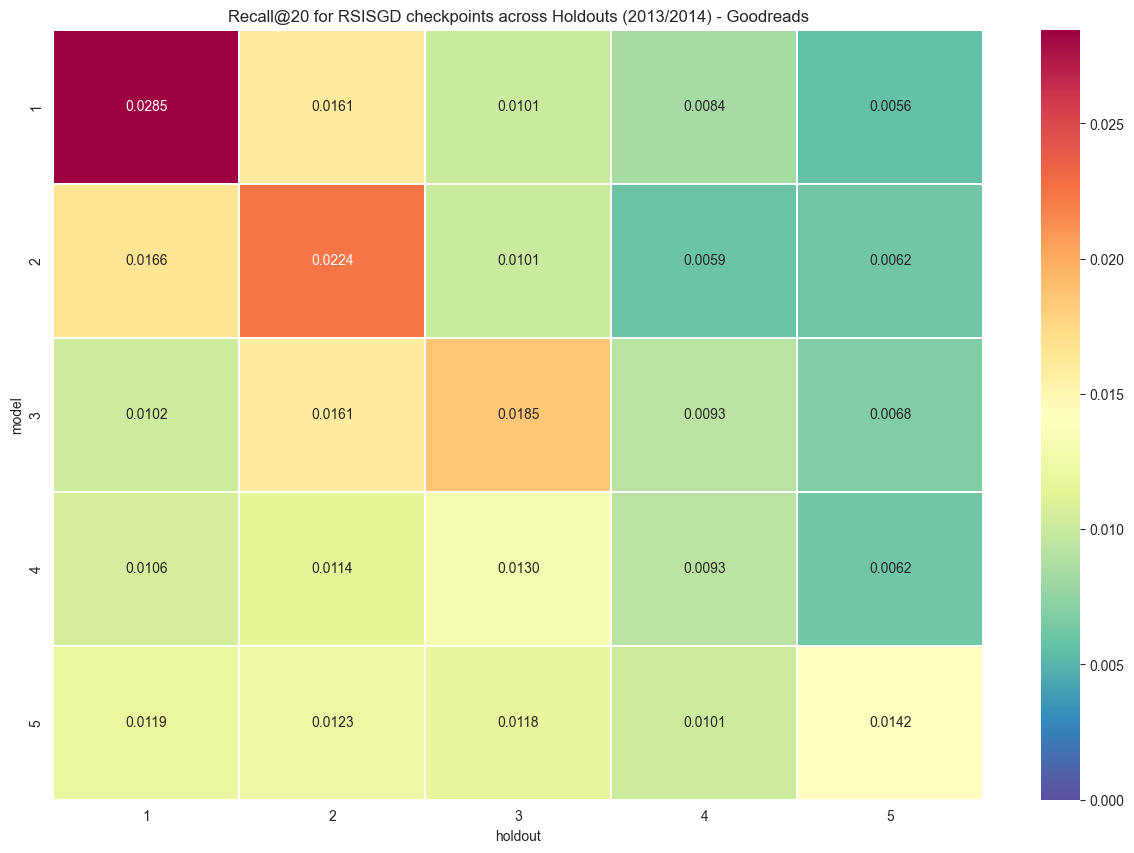

In [12]:
run_evaluate_RSISGD(data = interactions_df,
             interval_type = 'S',
             intervals_path = output_path+filename+'_semesters.joblib',
             use_data_unique_users = False,
             frequent_users_path = output_path+filename+'_frequent_users_'+str(frequent_users_thr)+'.joblib',
             buckets_path = output_path+filename+'_semesterly_buckets.joblib',
             holdouts_path = output_path+filename+'_semesterly_holdouts.joblib',
             cold_start_buckets = 1,
             to_grid_search = False,
             num_factors = num_factors,
             num_iter = num_iter,
             learn_rate = learn_rate,
             regularization = regularization,
             random_seed = random_seed,
             results_matrix_path = output_path+filename+'_semesterly_bucket_'+MODEL_NAME+'_results.csv',
             recall_heatmap_title = 'Recall@20 for '+MODEL_NAME+' checkpoints across Holdouts (2013/2014) - '+dataset_name,
             recall_heatmap_path = heatmaps_path+filename+'_semesterly_bucket_'+MODEL_NAME+'_heatmap.png',
             incrementalTraining_time_record_path = output_path+filename+'_semesterly_bucket_'+MODEL_NAME+'_training_time.joblib',
             evaluateHoldouts_time_record_path = output_path+filename+'_semesterly_bucket_'+MODEL_NAME+'_eval_time.joblib',
             eval_files_path = diversity_filepath+MODEL_NAME+'/'+filename+'_',
             save_eval_files = True)